Aim here is to perform a very simple analysis to check if the exposure regions is working correctly.

In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
import corner
import matplotlib.pyplot as plt
from matplotlib import rcParams

from NPTFit import nptfit # module for performing scan
from NPTFit import dnds_analysis # module for analysing the output

# 1 Exposure Region

Confirm that if we have a uniform exposure map and only a single exposure region the code can recover what we inject. As seen below it does a good job.

No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt


/zfs/nrodd/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/zfs/nrodd/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


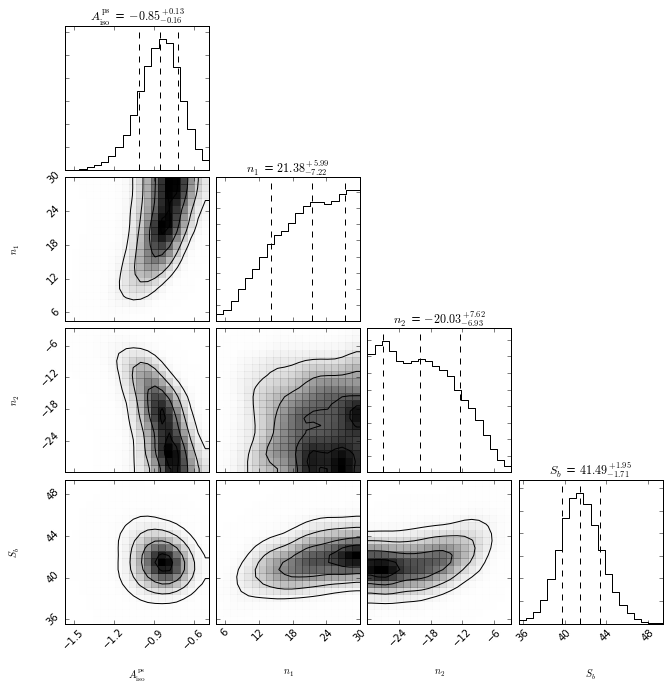

Flux fraction [16,50,84] percentiles: [  81.29971543   99.32435206  119.98749532]
Median of FFs over params: 98.615005914


In [2]:
# Setup data and exposure
nside = 2
nps = 30
psc = 40
ner = 1
emaxval = 1.0

npix = hp.nside2npix(nside)
exposure = np.zeros(npix)
exposure[0:npix/2] = 1.0
exposure[npix/2:npix] = emaxval
data = np.zeros(npix, dtype='int')
for ips in range(nps):
    loc = np.random.randint(npix)
    data[loc] += np.random.poisson(psc*exposure[loc])
totaldata = np.sum(data)

#hp.mollview(data,title='Fake Data')
#hp.mollview(exposure,title='Exposure Map')

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,30],[-30,1.95],[0.01,200]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500)

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

#print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

#print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(nptf_iso)*
                                                 np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)
                                                +1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100

# 2 Exposure Regions

Now we break the exposure region into two regions with values a factor of 2 apart, but keep nexp=1. This shouldn't work, but is just designed as a baseline to see what happens when we move away from this. As expected the code recovers a much larger Sb than is correct. Interestingly it also ends up a long way from a delta function.

93.7142857143
No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt


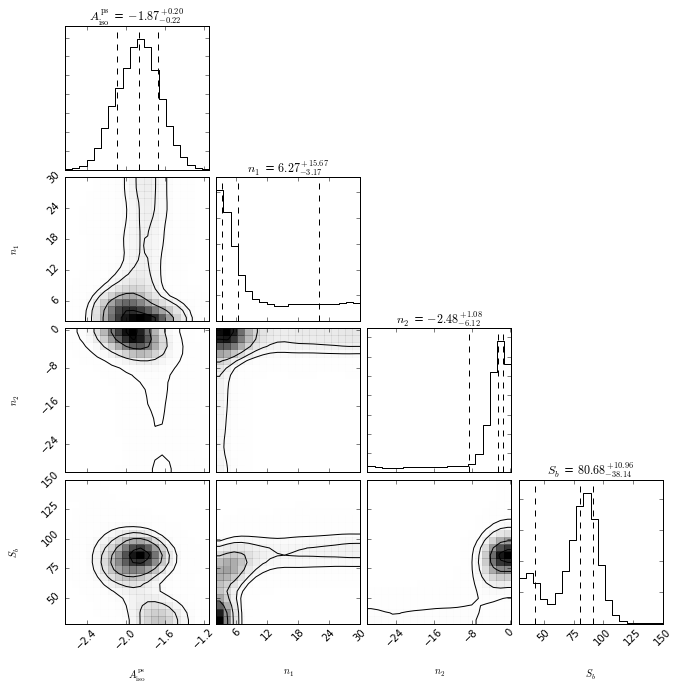

Flux fraction [16,50,84] percentiles: [  78.44033766   99.63803472  123.60357373]
Median of FFs over params: 99.3475052657


In [3]:
# Setup data and exposure
nside = 2
nps = 30
psc = 40
ner = 1
emaxval = 2.0

npix = hp.nside2npix(nside)
exposure = np.zeros(npix)
exposure[0:npix/2] = 1.0
exposure[npix/2:npix] = emaxval
data = np.zeros(npix, dtype='int')
for ips in range(nps):
    loc = np.random.randint(npix)
    data[loc] += np.random.poisson(psc*exposure[loc])
totaldata = np.sum(data)
print np.mean(data[np.where(data != 0)])

#hp.mollview(data,title='Fake Data')
#hp.mollview(exposure,title='Exposure Map')

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,30],[-30,1.95],[0.01,200]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500)

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

#print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

#print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(nptf_iso)*
                                                 np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)
                                                +1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100

Now we try this with 2 exposure regions (which is all there is). Critically it is not recovering Sb ~ 40 but rather 60, which we injected. **BUT** to understand this, note that this is the effective Sb being plotting, what was injected should be thought of as a flux, and Fb = Sbeff/mean(exposure). As mean(exposure)=1.5 we get Fb ~ 40, as required! Note also the FF works when calculated manually, but the quartiles aren't doing a very good job!


Note I've tested that the results below are stable if we change to npix exposure regions, increase nlive, or interestingly swap the NPTF template from 1/exp to exp or flat. This suggests there is a more fundamental bug.

No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt


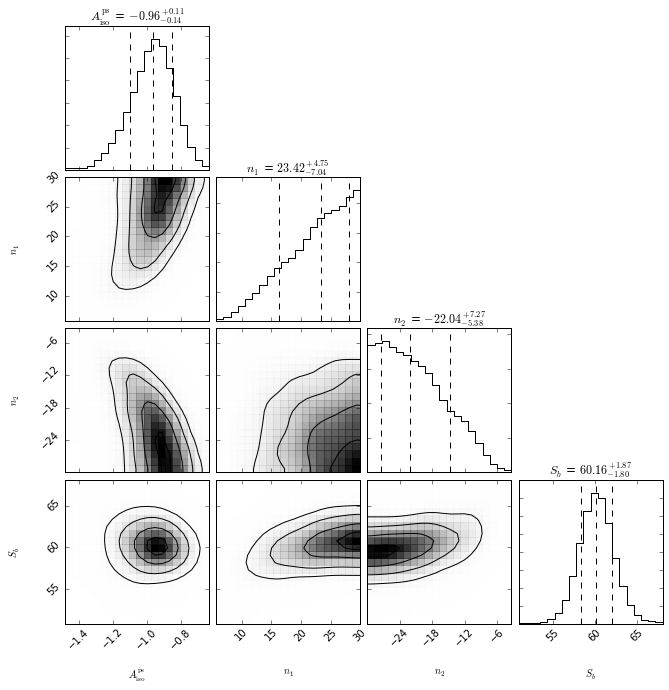

Flux fraction [16,50,84] percentiles: [  94.76703659  112.81729417  133.41445326]
Median of FFs over params: 99.5982018523


In [13]:
# Setup data and exposure
ner = 2 # can take this all the way to ner = npix and get the same answer

#hp.mollview(data,title='Fake Data')
#hp.mollview(exposure,title='Exposure Map')

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,30],[-30,1.95],[0.01,200]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500) # increasing nlive doesn't help

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

#print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

#print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(exposure**2*nptf_iso)*
                                                 np.array(Sb_non_poiss_post[0]/np.mean(exposure))**2*(1/(np.array(n_non_poiss_post[0])-2)
                                                +1/(2-np.array(n_non_poiss_post[1]))),50)/totaldata*100

Let's try a crazy case.

82.2272727273
No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt


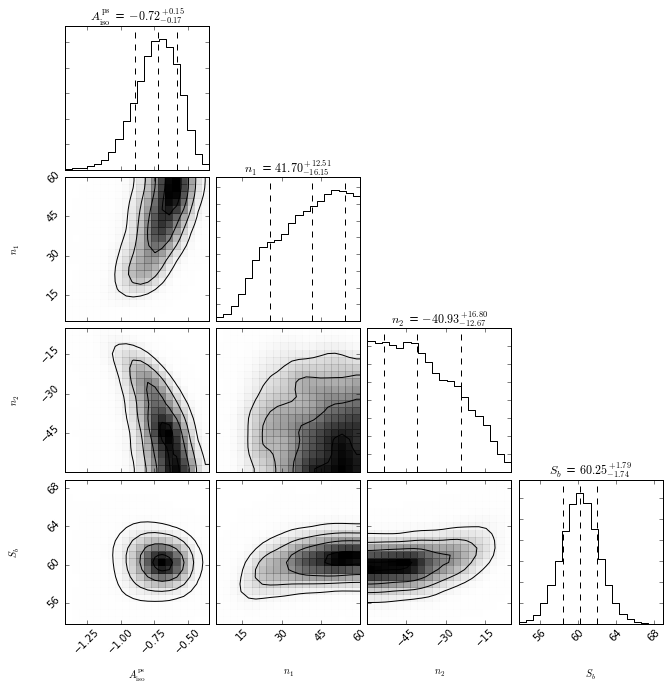

Median of FFs over params: 150.35520964


In [6]:
nside = 2
nps = 30
psc = 40
ner = 1
emaxval = 2.0

npix = hp.nside2npix(nside)
exposure = np.zeros(npix)
exposure[0:npix/2] = 1.0
exposure[npix/2:npix] = emaxval
data = np.zeros(npix, dtype='int')
for ips in range(nps):
    loc = np.random.randint(npix)
    data[loc] += np.random.poisson(psc*exposure[loc])
totaldata = np.sum(data)
totalflux = np.sum(data/exposure)
print np.mean(data[np.where(data != 0)])

# Setup data and exposure
ner = 2 # can take this all the way to ner = npix and get the same answer

#hp.mollview(data,title='Fake Data')
#hp.mollview(exposure,title='Exposure Map')

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
#nptf_iso = exposure
#nptf_iso = np.ones(npix)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,60],[-60,1.95],[0.01,200]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500) # increasing nlive doesn't help

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

#print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

#an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
#plt.close()
#print "Flux fraction [16,50,84] percentiles:",an.qs_comp

#print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
print "Median of FFs over params:",np.percentile(np.array(Aiso_non_poiss_post)*np.sum(np.ones(npix))*
                                                 np.array(Sb_non_poiss_post[0])**2*(1/(np.array(n_non_poiss_post[0])-2)
                                                +1/(2-np.array(n_non_poiss_post[1]))),50)/totalflux*100

# Test a more Dramatic Exposure Difference

No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt


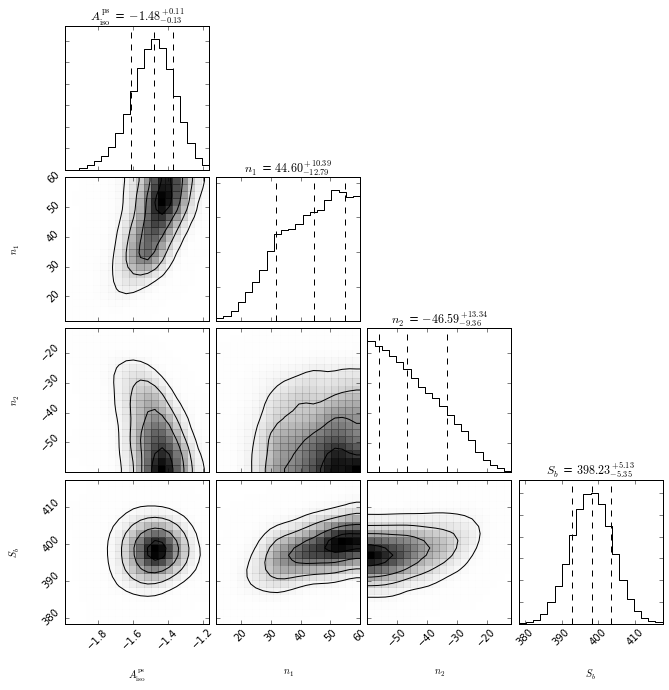

Flux fraction [16,50,84] percentiles: [ 216.89451399  262.55217774  313.73955165]
[16,50,84] of FFs (manual calc): 77.8106747999 93.9106846764 112.483217065


In [12]:
nside = 2
nps = 30
psc = 80
emaxval = 9.0

npix = hp.nside2npix(nside)
exposure = np.zeros(npix)
exposure[0:npix/2] = 1.0
exposure[npix/2:npix] = emaxval
data = np.zeros(npix, dtype='int')
for ips in range(nps):
    loc = np.random.randint(npix)
    data[loc] += np.random.poisson(psc*exposure[loc])
totaldata = np.sum(data)
totalflux = np.sum(data/exposure)
#print np.mean(data[np.where(data != 0)])

# Setup data and exposure
ner = 2 # can take this all the way to ner = npix and get the same answer

#hp.mollview(data,title='Fake Data')
#hp.mollview(exposure,title='Exposure Map')

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
#nptf_iso = exposure
#nptf_iso = np.ones(npix)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,60],[-60,1.95],[0.01,600]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500) # increasing nlive doesn't help

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

#print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

#print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
FFarr = np.array(np.array(Aiso_non_poiss_post)*np.sum(exposure**2*nptf_iso)*
                                                 np.array(Sb_non_poiss_post[0]/np.mean(exposure))**2
                                                 *(1/(np.array(n_non_poiss_post[0])-2)
                                                 +1/(2-np.array(n_non_poiss_post[1])))/totaldata*100)

print "[16,50,84] of FFs (manual calc):",np.percentile(FFarr,16),np.percentile(FFarr,50),np.percentile(FFarr,84)

# Test which template is preferred

As seen below the 1/exp template gives the best fit to the data/

In [13]:
nside = 2
nps = 30
psc = 80
emaxval = 9.0

npix = hp.nside2npix(nside)
exposure = np.zeros(npix)
exposure[0:npix/2] = 1.0
exposure[npix/2:npix] = emaxval
data = np.zeros(npix, dtype='int')
for ips in range(nps):
    loc = np.random.randint(npix)
    data[loc] += np.random.poisson(psc*exposure[loc])
totaldata = np.sum(data)

# 1/exp
ner = 2 # can take this all the way to ner = npix and get the same answer

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,60],[-60,1.95],[0.01,600]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500) # increasing nlive doesn't help
n.load_scan()
an=dnds_analysis.Analysis(n)
be1, l_be_err = an.get_log_evidence()
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

print ""
print "1/exp"
print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"
print "Injected Fb:",Sb/np.mean(exposure)

# exp
ner = 2 # can take this all the way to ner = npix and get the same answer

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = exposure/np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,60],[-60,1.95],[0.01,600]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500) # increasing nlive doesn't help
n.load_scan()
an=dnds_analysis.Analysis(n)
be2, l_be_err = an.get_log_evidence()
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

print ""
print "exp"
print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"
print "Injected Fb:",Sb/np.mean(exposure)

# Uniform
ner = 2 # can take this all the way to ner = npix and get the same answer

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-3,0],[2.05,60],[-60,1.95],[0.01,600]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500) # increasing nlive doesn't help
n.load_scan()
an=dnds_analysis.Analysis(n)
be3, l_be_err = an.get_log_evidence()
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

print ""
print "uniform"
print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"
print "Injected Fb:",Sb/np.mean(exposure)

print ""
print "Log Bayesian Evidence for 1/exp over exp:",be1-be2
print "Log Bayesian Evidence for 1/exp over flat:",be1-be3
print "Log Bayesian Evidence for exp over flat:",be2-be3

No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt

1/exp
Median (A, n1, n2, Sb): ( 0.0339485539128 ,  46.4346550037 ,  -45.9305969401 ,  393.747365751 )
Injected Fb: 78.7494731501
No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt

exp
Median (A, n1, n2, Sb): ( 0.0207225695083 ,  46.0637275102 ,  -46.2614080758 ,  393.531429772 )
Injected Fb: 78.7062859545
No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt

uniform
Median (A, n1, n2, Sb): ( 0.0337833722829 ,  45.782380423 ,  -46.435449708 ,  393.809751753 )
Injected Fb: 78.7619503505

Log Bayesian Evidence for 1/exp over exp: 23.5707932299
Log Bayesian Evidence for 1/exp over flat: 4.4271976272
Log Bay

# Is the Flux fraction better constrained if we restricted priors

It might be but this fluctuates a fair bit.

No mask set; defaulting to a blank mask
The number of parameters to be fit is 4
  analysing data from /zfs/nrodd/NPTFitCGamma/NPTFit/examples/chains/Example10/.txt


/zfs/nrodd/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/zfs/nrodd/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


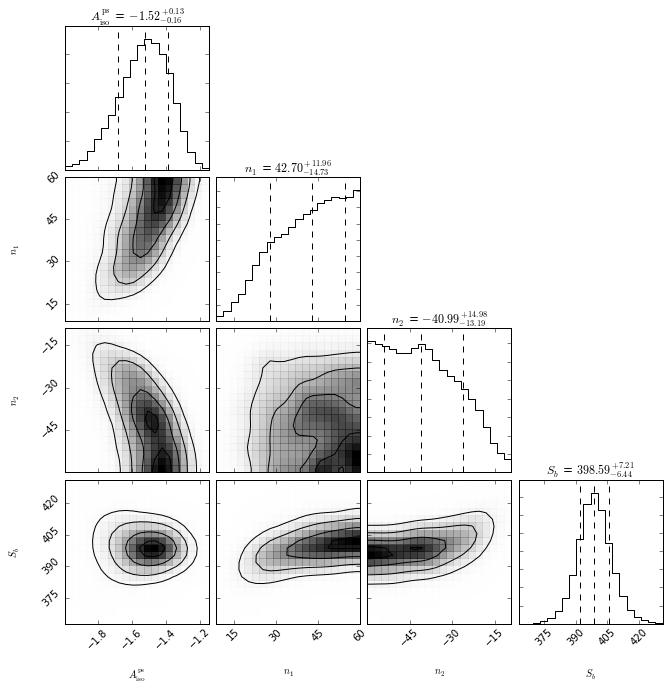

Flux fraction [16,50,84] percentiles: [ 246.04637119  295.2573752   350.85928907]
[16,50,84] of FFs (manual calc): 87.5510129586 105.789102857 125.317278687


/zfs/nrodd/anaconda/lib/python2.7/site-packages/NPTFit-0.1.1-py2.7-linux-x86_64.egg/NPTFit/dnds_analysis.py:260: RuntimeWarning: invalid value encountered in divide


In [2]:
nside = 2
nps = 30
psc = 80
emaxval = 9.0

npix = hp.nside2npix(nside)
exposure = np.zeros(npix)
exposure[0:npix/2] = 1.0
exposure[npix/2:npix] = emaxval
data = np.zeros(npix, dtype='int')
for ips in range(nps):
    loc = np.random.randint(npix)
    data[loc] += np.random.poisson(psc*exposure[loc])
totaldata = np.sum(data)
totalflux = np.sum(data/exposure)
#print np.mean(data[np.where(data != 0)])

# Setup data and exposure
ner = 2 # can take this all the way to ner = npix and get the same answer

n = nptfit.NPTF(tag='Example10')
n.load_data(data, exposure)
nptf_iso = np.ones(npix)/exposure*np.mean(exposure)
n.add_template(nptf_iso, 'iso')
n.add_non_poiss_model('iso',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-2,-1],[2.05,60],[-60,1.95],[350,450]],
                      [True,False,False,False])
n.configure_for_scan(nexp=ner)
n.perform_scan(nlive=500) # increasing nlive doesn't help

# Load and analyze the output
n.load_scan()
an=dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

# Manual calculation of the FF
Aiso_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('iso')
A = np.percentile(Aiso_non_poiss_post,50)
n1 = np.percentile(n_non_poiss_post[0],50)
n2 = np.percentile(n_non_poiss_post[1],50)
Sb = np.percentile(Sb_non_poiss_post[0],50)

#print "Median (A, n1, n2, Sb): (",A,", ",n1,", ",n2,", ",Sb,")"

an.plot_intensity_fraction_non_poiss('iso', bins=800, color='tomato', label='Iso PS',smin=0.01, smax=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

#print "Median of each param FF:",A*np.sum(nptf_iso)*Sb**2*(1/(n1-2)+1/(2-n2))/totaldata*100
FFarr = np.array(np.array(Aiso_non_poiss_post)*np.sum(exposure**2*nptf_iso)*
                                                 np.array(Sb_non_poiss_post[0]/np.mean(exposure))**2
                                                 *(1/(np.array(n_non_poiss_post[0])-2)
                                                 +1/(2-np.array(n_non_poiss_post[1])))/totaldata*100)

print "[16,50,84] of FFs (manual calc):",np.percentile(FFarr,16),np.percentile(FFarr,50),np.percentile(FFarr,84)

Can changing the default params help here, because integrating a Delta function. I'm not really sure about this, might need to review. Can also put in analytic forms.

In [14]:
an.plot_intensity_fraction_non_poiss('iso', bins=1000, color='tomato', label='Iso PS',smin=0.1, smax=1000,nsteps=10000)
plt.close()
print "Flux fraction [16,50,84] percentiles:",an.qs_comp

Flux fraction [16,50,84] percentiles: [ 243.3052923   294.00969988  348.2589733 ]
